# Implementation of baseline without GRL: SVHN (Source) and MNIST (Target)

In [23]:
import torch
import torchvision
import torch.nn as nn

In [24]:
torch.__version__

'2.7.1+cu126'

In [25]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [26]:
import numpy as np
import datetime
import os, sys

In [27]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [28]:
MODEL_NAME = 'NN'
print("cuda") if torch.cuda.is_available() else print("cpu")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda


In [29]:
class FeatureExtractor(nn.Module):
    """
        Feature Extractor
    """
    def __init__(self, in_channel=1, hidden_dims=512):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, hidden_dims, 3, padding=1),
            nn.BatchNorm2d(hidden_dims),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),
        )
        
    def forward(self, x):
        h = self.conv(x).squeeze() # (N, hidden_dims)
        return h

In [30]:
class Classifier(nn.Module):
    """
        Classifier
    """
    def __init__(self, input_size=512, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes),
        )
        
    def forward(self, h):
        c = self.layer(h)
        return c

In [31]:
F = FeatureExtractor().to(DEVICE)
C = Classifier().to(DEVICE)

In [32]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5],
                         std=[0.5])
])

In [33]:
mnist_train = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data/', train=False, transform=transform, download=True)

In [34]:
svhn_train = datasets.SVHN(root='../data/', split='train', transform=transform, download=True)
svhn_test = datasets.SVHN(root='../data/', split='test', transform=transform, download=True)

In [35]:
batch_size = 64

In [36]:
svhn_train.data.shape

(73257, 3, 32, 32)

In [37]:
svhn_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
eval_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=False)

In [38]:
xe = nn.CrossEntropyLoss()

In [39]:
F_opt = torch.optim.Adam(F.parameters())
C_opt = torch.optim.Adam(C.parameters())

In [40]:
max_epoch = 50
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_batches = len(mnist_train)//batch_size
# lamda = 0.01

### Training Code



In [41]:
mnist_set = iter(mnist_loader)

def sample_mnist(step, n_batches):
    global mnist_set
    if step % n_batches == 0:
        mnist_set = iter(mnist_loader)
    return next(mnist_set)

In [42]:
ll_c = []
s_acc_lst = []
t_acc_lst = []

In [43]:
#Old Code without Logging
'''
for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)
        # Training Discriminator
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)
        
        c = C(F(src))
        Lc = xe(c, labels)
        
        F.zero_grad()
        C.zero_grad()
        
        Lc.backward()
        
        C_opt.step()
        F_opt.step()
        
        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, C Loss: {:.4f} ---- {}'.format(epoch, max_epoch, step, Lc.item(), dt))
            ll_c.append(Lc.item())
        
        if step % 500 == 0:
            F.eval()
            C.eval()
            with torch.no_grad():
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (src, labels) in enumerate(eval_loader):
                    src, labels = src.to(DEVICE), labels.to(DEVICE)
                    c = C(F(src))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(eval_loader.dataset)
                print('***** Source Accuracy: {:.4f}, Step: {}'.format(acc, step))
                s_acc_lst.append(acc)
                
                corrects = torch.zeros(1).to(DEVICE)
                for idx, (tgt, labels) in enumerate(test_loader):
                    tgt, labels = tgt.to(DEVICE), labels.to(DEVICE)
                    c = C(F(tgt))
                    _, preds = torch.max(c, 1)
                    corrects += (preds == labels).sum()
                acc = corrects.item() / len(test_loader.dataset)
                print('***** Target Accuracy : {:.4f}, Step: {}'.format(acc, step))
                t_acc_lst.append(acc)
                
            F.train()
            C.train()
        step += 1
'''

"\nfor epoch in range(1, max_epoch+1):\n    for idx, (src_images, labels) in enumerate(svhn_loader):\n        tgt_images, _ = sample_mnist(step, n_batches)\n        # Training Discriminator\n        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)\n\n        c = C(F(src))\n        Lc = xe(c, labels)\n\n        F.zero_grad()\n        C.zero_grad()\n\n        Lc.backward()\n\n        C_opt.step()\n        F_opt.step()\n\n        if step % 100 == 0:\n            dt = datetime.datetime.now().strftime('%H:%M:%S')\n            print('Epoch: {}/{}, Step: {}, C Loss: {:.4f} ---- {}'.format(epoch, max_epoch, step, Lc.item(), dt))\n            ll_c.append(Lc.item())\n\n        if step % 500 == 0:\n            F.eval()\n            C.eval()\n            with torch.no_grad():\n                corrects = torch.zeros(1).to(DEVICE)\n                for idx, (src, labels) in enumerate(eval_loader):\n                    src, labels = src.to(DEVICE), labels.to(DEVICE)\n

In [44]:
for epoch in range(1, max_epoch+1):
    for idx, (src_images, labels) in enumerate(svhn_loader):
        tgt_images, _ = sample_mnist(step, n_batches)
        # Training Discriminator
        src, labels, tgt = src_images.to(DEVICE), labels.to(DEVICE), tgt_images.to(DEVICE)
        
        c = C(F(src))
        Lc = xe(c, labels)
        
        F.zero_grad()
        C.zero_grad()
        
        Lc.backward()
        
        C_opt.step()
        F_opt.step()
        
        if step % 100 == 0:
            dt = datetime.datetime.now().strftime('%H:%M:%S')
            print('Epoch: {}/{}, Step: {}, C Loss: {:.4f} ---- {}'.format(epoch, max_epoch, step, Lc.item(), dt))
            ll_c.append(Lc.item())

        if step % 500 == 0:
            F.eval()
            C.eval()
        
            # --- Source Domain Evaluation ---
            with torch.no_grad():
                correct_src = 0
                for src_batch, src_labels in eval_loader:
                    src_batch = src_batch.to(DEVICE)
                    src_labels = src_labels.to(DEVICE)
                    preds = C(F(src_batch)).argmax(1)
                    correct_src += (preds == src_labels).sum().item()
                src_acc = correct_src / len(eval_loader.dataset)
                print('***** Source Accuracy: {:.4f}, Step: {}'.format(src_acc, step))
                s_acc_lst.append(src_acc)
        
            # --- Target Domain: Sample Logging ---
            with torch.no_grad():
                logged = 0
                print("\n🧪 Sample Predictions on Target Domain (MNIST):")
                for tgt_batch, tgt_labels in test_loader:
                    tgt_batch = tgt_batch.to(DEVICE)
                    tgt_labels = tgt_labels.to(DEVICE)
                    preds = C(F(tgt_batch)).argmax(1)
        
                    for i in range(len(tgt_labels)):
                        if logged >= 15:
                            break
                        pred = preds[i].item()
                        true = tgt_labels[i].item()
                        status = "✅" if pred == true else "❌"
                        print(f"{status} Sample {logged+1}: Pred = {pred}, True = {true}")
                        logged += 1
                    if logged >= 15:
                        break
        
            # --- Target Domain Accuracy (FULL) ---
            with torch.no_grad():
                correct_tgt = 0
                for tgt_batch, tgt_labels in test_loader:
                    tgt_batch = tgt_batch.to(DEVICE)
                    tgt_labels = tgt_labels.to(DEVICE)
                    preds = C(F(tgt_batch)).argmax(1)
                    correct_tgt += (preds == tgt_labels).sum().item()
        
                tgt_acc = correct_tgt / len(test_loader.dataset)
                print('***** Target Accuracy: {:.4f}, Step: {}'.format(tgt_acc, step))
                t_acc_lst.append(tgt_acc)
        
            F.train()
            C.train()
        step += 1

Epoch: 1/50, Step: 0, C Loss: 2.3036 ---- 10:38:49
***** Source Accuracy: 0.0733, Step: 0

🧪 Sample Predictions on Target Domain (MNIST):
❌ Sample 1: Pred = 1, True = 7
❌ Sample 2: Pred = 1, True = 2
✅ Sample 3: Pred = 1, True = 1
❌ Sample 4: Pred = 1, True = 0
❌ Sample 5: Pred = 1, True = 4
✅ Sample 6: Pred = 1, True = 1
❌ Sample 7: Pred = 1, True = 4
❌ Sample 8: Pred = 1, True = 9
❌ Sample 9: Pred = 1, True = 5
❌ Sample 10: Pred = 1, True = 9
❌ Sample 11: Pred = 1, True = 0
❌ Sample 12: Pred = 1, True = 6
❌ Sample 13: Pred = 1, True = 9
❌ Sample 14: Pred = 1, True = 0
✅ Sample 15: Pred = 1, True = 1
***** Target Accuracy: 0.1233, Step: 0
Epoch: 1/50, Step: 100, C Loss: 2.1624 ---- 10:39:07
Epoch: 1/50, Step: 200, C Loss: 2.0791 ---- 10:39:13
Epoch: 1/50, Step: 300, C Loss: 1.9659 ---- 10:39:19
Epoch: 1/50, Step: 400, C Loss: 1.6924 ---- 10:39:24
Epoch: 1/50, Step: 500, C Loss: 1.6406 ---- 10:39:28
***** Source Accuracy: 0.3627, Step: 500

🧪 Sample Predictions on Target Domain (MNIST)

## Visualize Sample

In [45]:
import matplotlib.pyplot as plt

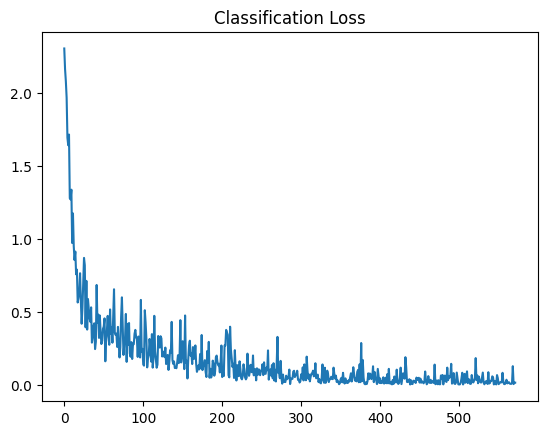

In [46]:
plt.title("Classification Loss")
plt.plot(range(len(ll_c)), ll_c)

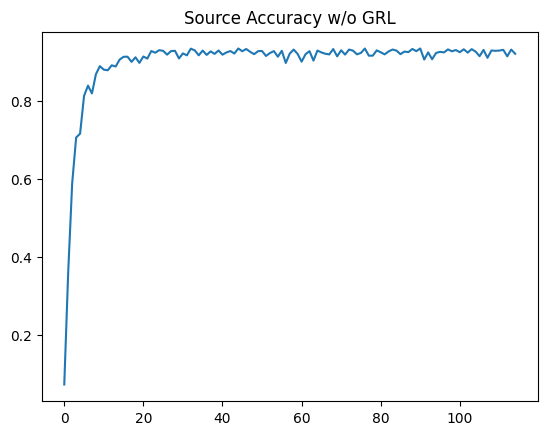

In [47]:
plt.title("Source Accuracy w/o GRL")
plt.plot(range(len(s_acc_lst)), s_acc_lst)

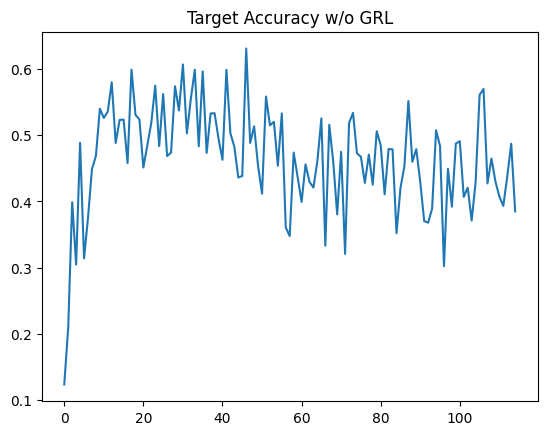

In [48]:
plt.title("Target Accuracy w/o GRL")
plt.plot(range(len(t_acc_lst)), t_acc_lst)

In [49]:
print("Maximum Source Accuracy w/o GRL:",max(s_acc_lst))
print("Maximum Target Accuracy w/o GRL:",max(t_acc_lst))

Maximum Source Accuracy w/o GRL: 0.9344268592501537
Maximum Target Accuracy w/o GRL: 0.631


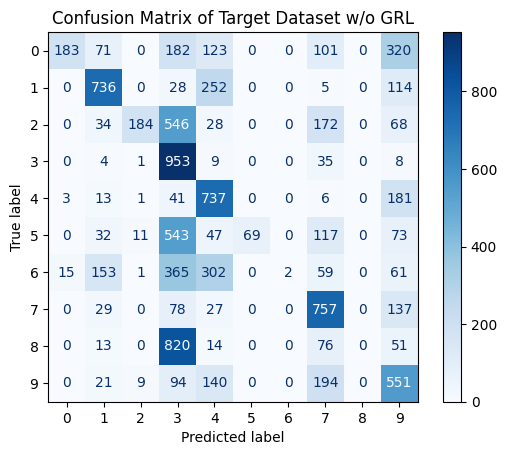

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

# Set models to evaluation mode
F.eval()
C.eval()

all_preds = []
all_labels = []

# Run on test data
with torch.no_grad():
    for data, labels in test_loader:  # Replace with your actual test DataLoader
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        # Forward pass through feature extractor and classifier
        features = F(data)
        outputs = C(features)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix of Target Dataset w/o GRL")
plt.show()